<a href="https://colab.research.google.com/github/snakeway8/Projects/blob/main/credit_score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import  RandomForestClassifier

In [122]:
df = pd.read_csv('/content/credit_train_clean.csv').drop(['Name','SSN','ID','Customer_ID'],axis=1)

In [123]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


### Data Prep & EDA

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  int64  
 1   Age                       100000 non-null  float64
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  float64
 6   Num_Credit_Card           100000 non-null  float64
 7   Interest_Rate             100000 non-null  float64
 8   Num_of_Loan               100000 non-null  float64
 9   Type_of_Loan              100000 non-null  object 
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

In [125]:
df['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


In [126]:
# This transformation simplifies the classification problem, making it suitable for binary classification models
df["Credit_Score"] = df["Credit_Score"].map({
                                                "Good": "Good or Standard",
                                                "Standard":  "Good or Standard",
                                                "Poor": "Poor"})

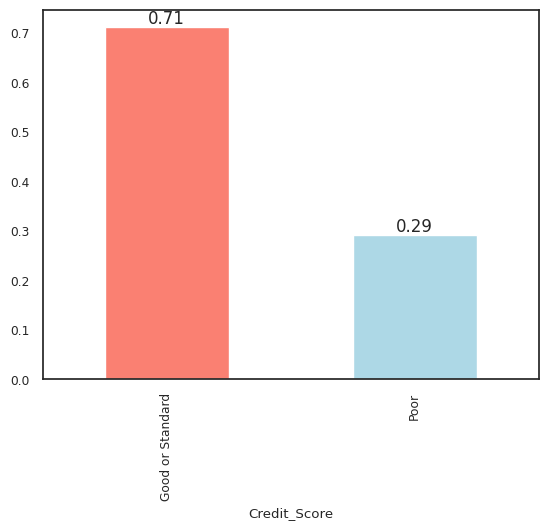

In [127]:
import matplotlib.pyplot as plt

ax = df['Credit_Score'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'lightblue'])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=12)

plt.show()


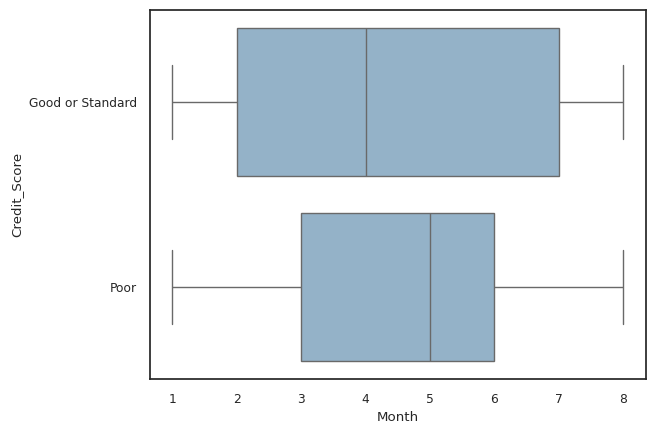

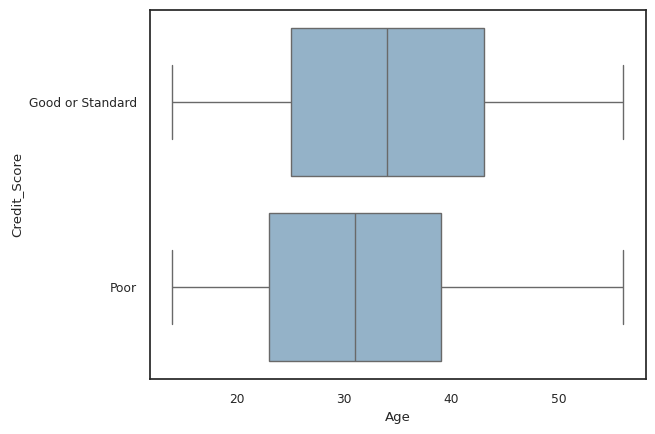

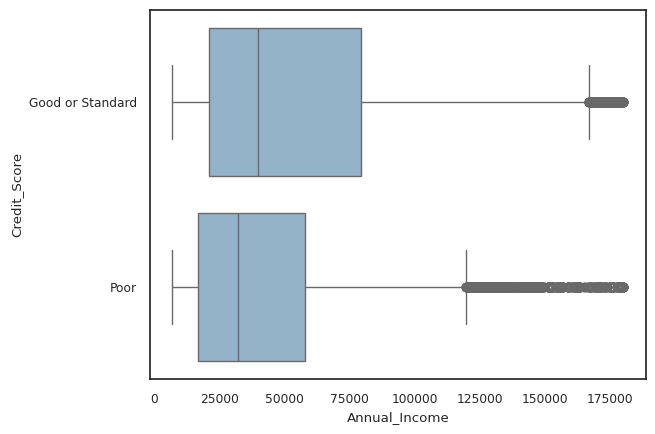

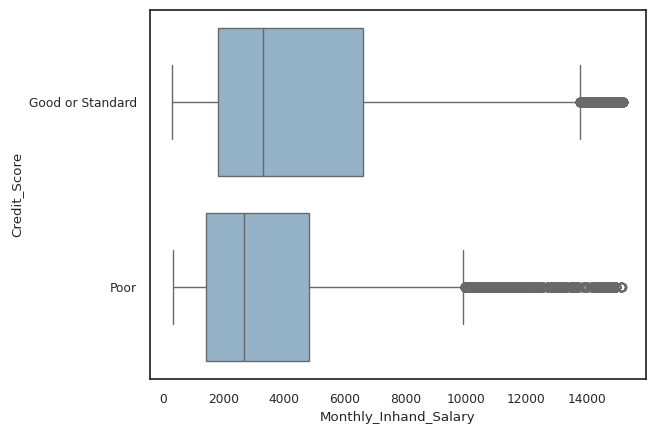

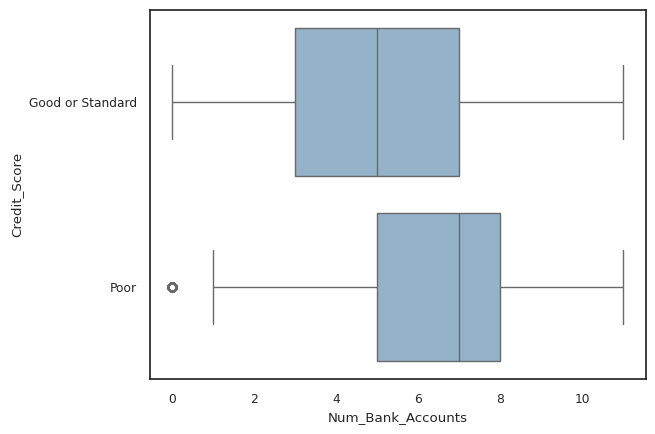

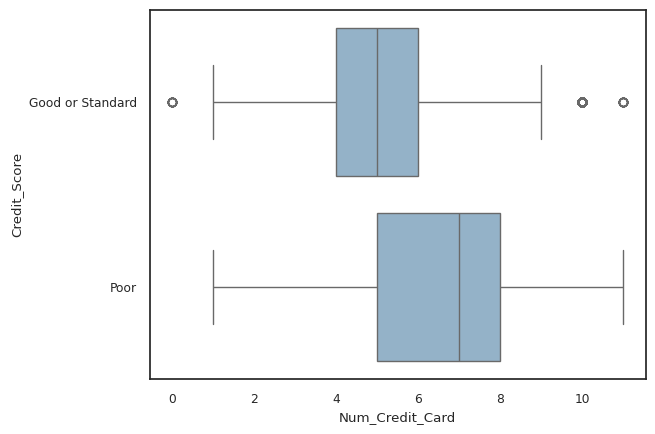

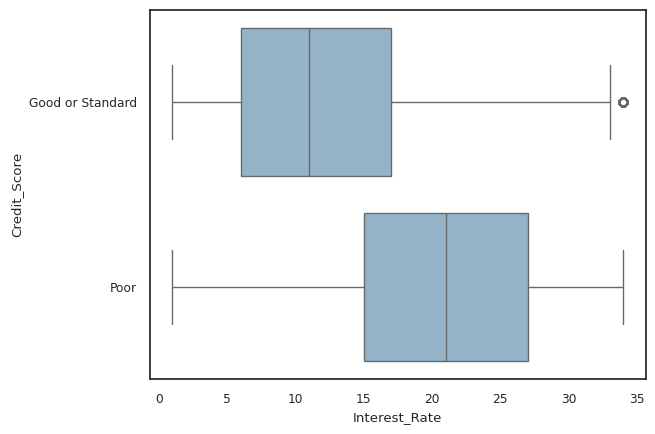

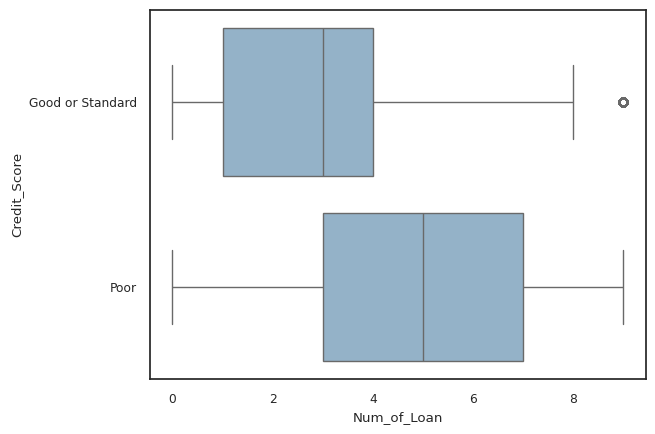

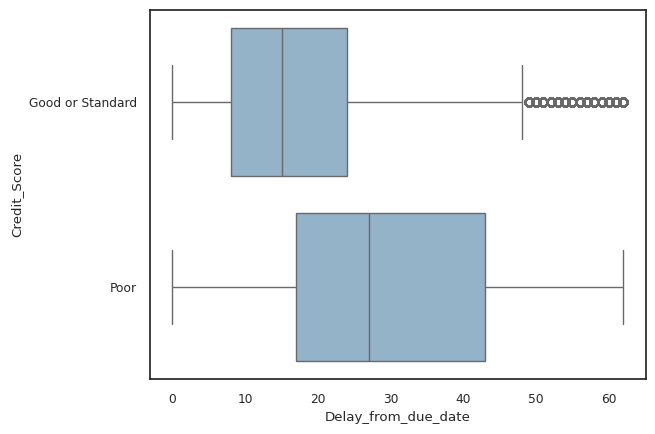

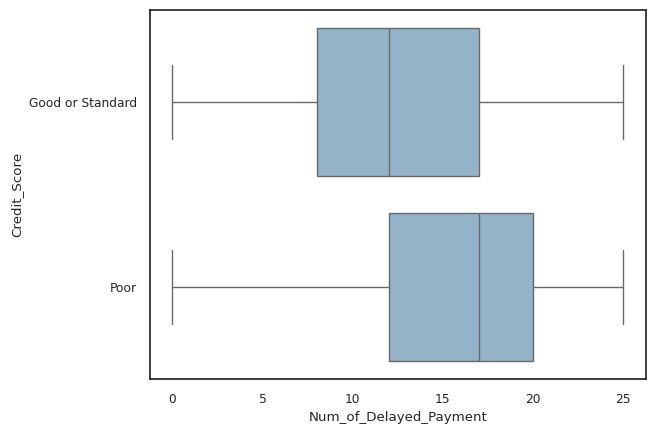

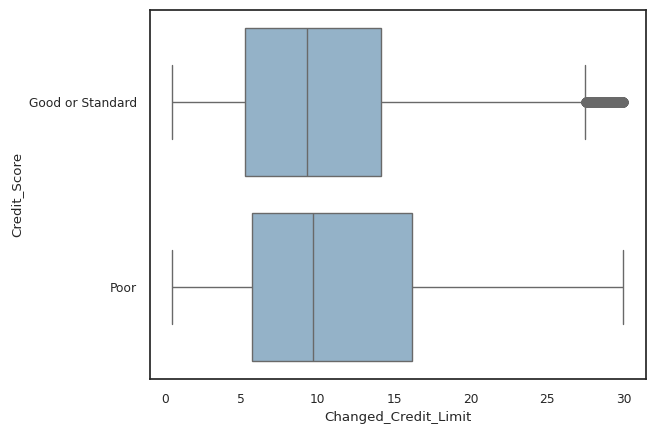

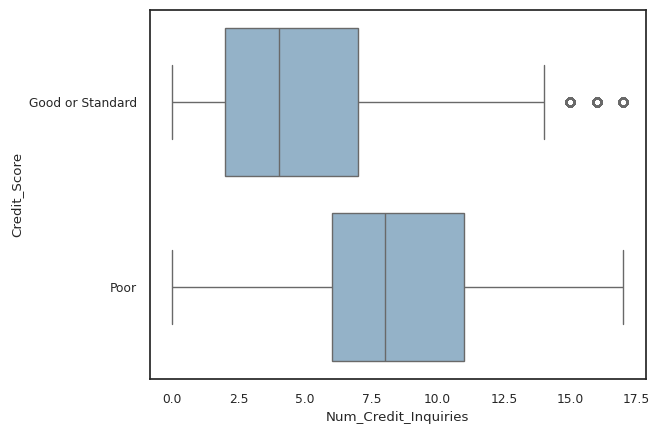

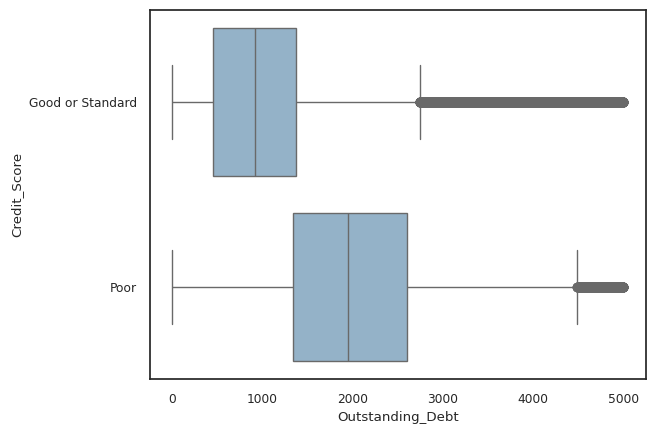

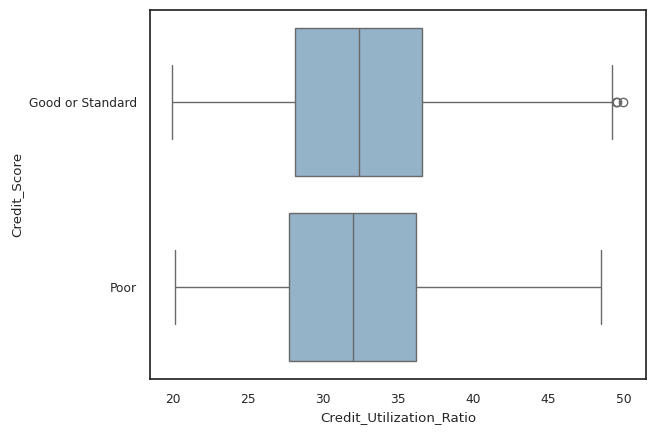

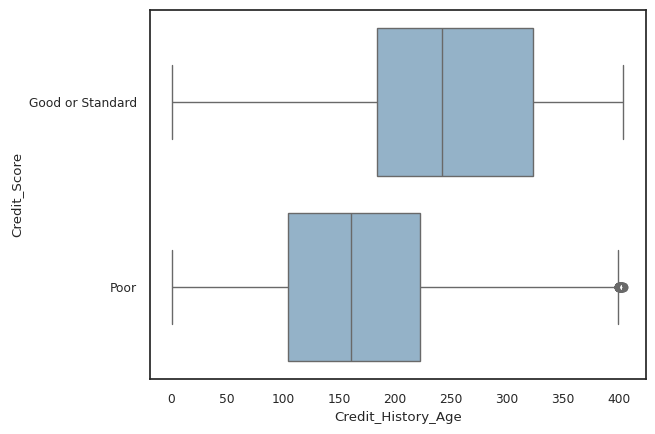

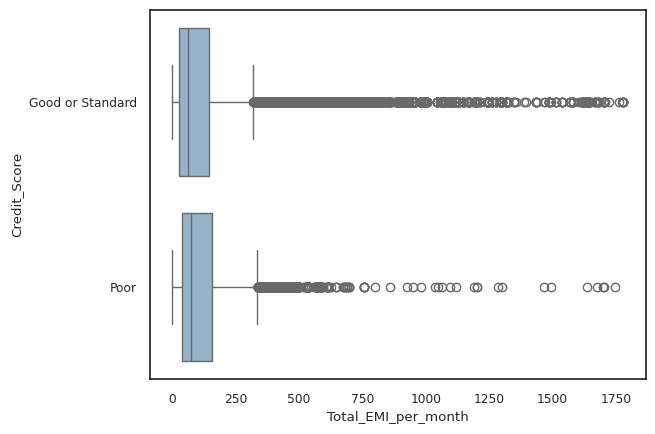

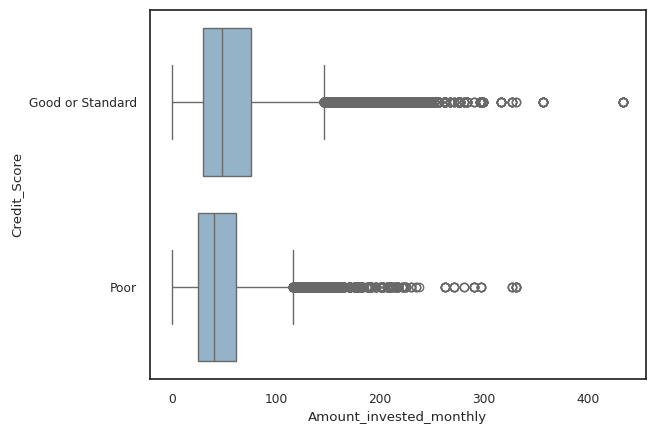

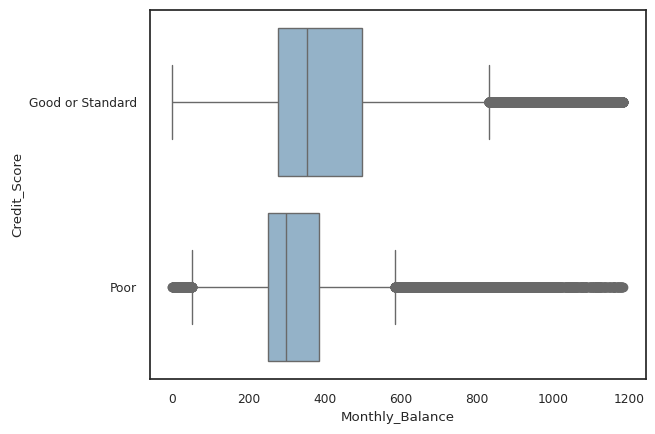

In [128]:
def num_plotter(data, target):
    for col in data.select_dtypes(["int", "float"]):
        sns.boxplot(data=data, x=col, y=target, #stat="percent", kde=True, bins=20
                   )
        plt.show()

num_plotter(df, "Credit_Score")


In [129]:
df['target']= np.where(df['Credit_Score']=='Poor',0,1)

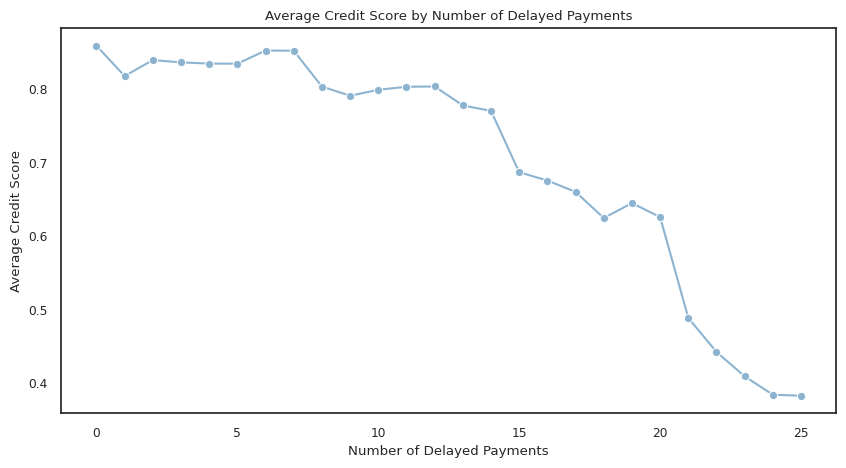

In [130]:
df_grouped = df.groupby("Num_of_Delayed_Payment")["target"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped, x="Num_of_Delayed_Payment", y="target", marker="o")
plt.xlabel("Number of Delayed Payments")
plt.ylabel("Average Credit Score")
plt.title("Average Credit Score by Number of Delayed Payments")
plt.show()

In [131]:
def categorize_by_first_word(loan_type):
    return loan_type.split(',')[0]

df['Type_of_Loan'] = df['Type_of_Loan'].apply(categorize_by_first_word)

In [132]:
type_loan_group = df[df['Type_of_Loan']!='No Data']. groupby('Type_of_Loan').agg(loans_number = ('Type_of_Loan','count'),\
                                                                                 mean_credit_score=('target','mean')).reset_index()
type_loan_group.sort_values('mean_credit_score', ascending = False)

,Type_of_Loan,loans_number,mean_credit_score
2,debt consolidation loan,9648,0.696310
8,student loan,9672,0.693755
4,mortgage loan,9632,0.691445
3,home equity loan,9360,0.691239
7,personal loan,10200,0.688431
1,credit-builder loan,10416,0.687404
6,payday loan,10248,0.686085
5,not specified,9848,0.678615
0,auto loan,9568,0.676839


In [133]:
df['income_category'] = pd.qcut(df['Annual_Income'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'])

In [134]:
df['Delayed_Payment_Group'] = pd.qcut(df['Num_of_Delayed_Payment'], q=3, labels=['low', 'medium', 'high'])

In [135]:
df = df.drop(columns=['Month','Credit_Score'])

In [136]:
occupation_group = df.groupby('Occupation').agg(median_salary = ('Monthly_Inhand_Salary','median'),median_annual_income = ('Annual_Income','median'),
                                            mean_loans = ('Num_of_Loan','mean'),mean_credit_score =('target','mean'))
occupation_group. sort_values(by = 'mean_credit_score', ascending= False)

,median_salary,median_annual_income,mean_loans,mean_credit_score
Occupation,,,,
Media_Manager,3138.630939,36991.340,3.464286,0.737500
Architect,3154.294167,37827.770,3.422040,0.728165
Doctor,3049.826667,35802.820,3.697929,0.725335
Lawyer,2894.421667,35223.940,3.479143,0.723083
Musician,3151.281667,38486.445,3.448363,0.718829
Journalist,2909.118333,34742.740,3.402693,0.718482
Developer,3028.180000,36422.830,3.605952,0.713690
Manager,3238.930000,38437.180,3.541045,0.711443
Mechanic,3074.806667,36821.000,3.608028,0.698347


In [137]:
income_group = df.groupby(['Occupation','income_category'],observed=False)['target'].mean().reset_index()
income_group = income_group.rename(columns = {'target':'mean_credit_score'}).round(2)
income_group.pivot_table(index='income_category', columns='Occupation', values='mean_credit_score', fill_value=0)


<ipython-input-137-77bde6a5c1cb>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  income_group.pivot_table(index='income_category', columns='Occupation', values='mean_credit_score', fill_value=0)


Occupation,Accountant,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer
income_category,,,,,,,,,,,,,,,
low,0.58,0.60,0.60,0.59,0.61,0.59,0.61,0.61,0.57,0.57,0.59,0.59,0.56,0.55,0.57
medium-low,0.77,0.74,0.80,0.78,0.73,0.75,0.78,0.74,0.76,0.74,0.76,0.76,0.76,0.79,0.70
medium-high,0.64,0.67,0.63,0.71,0.63,0.59,0.68,0.69,0.67,0.67,0.73,0.71,0.65,0.63,0.70
high,0.82,0.89,0.83,0.84,0.82,0.83,0.80,0.83,0.84,0.83,0.86,0.81,0.81,0.82,0.82


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

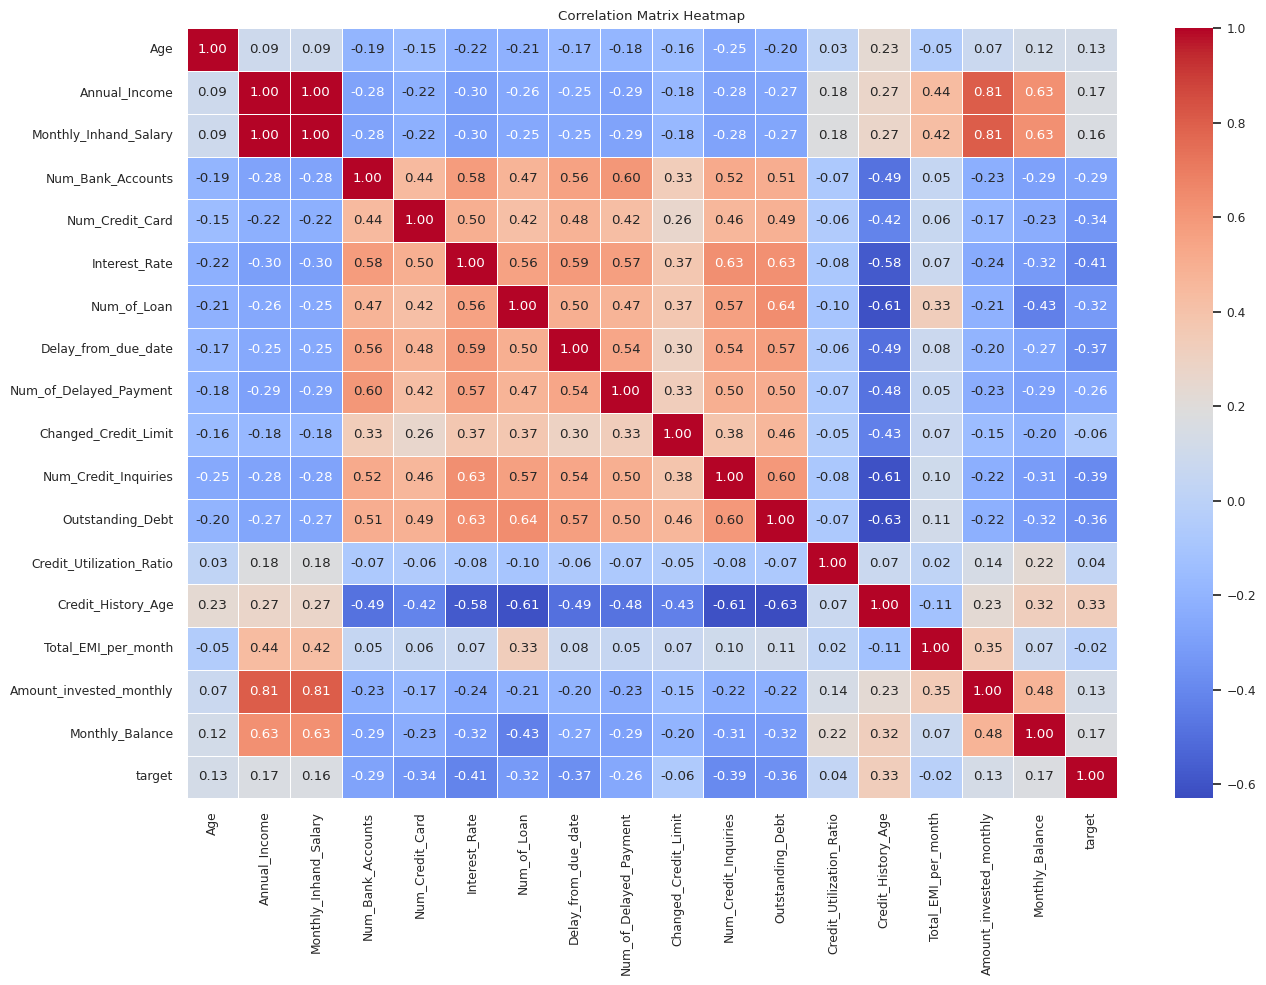

In [138]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title("Correlation Matrix Heatmap")

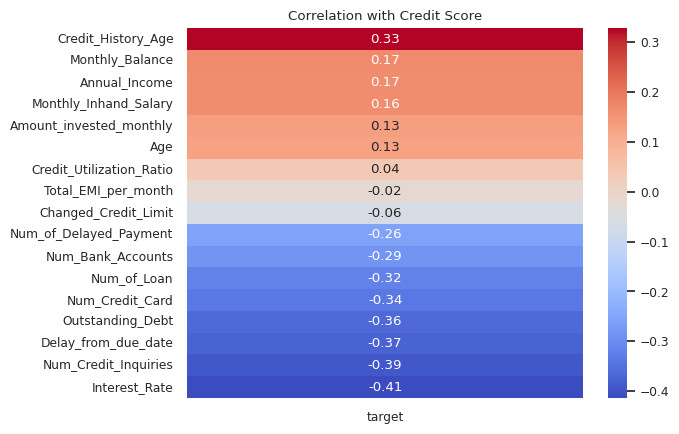

In [139]:

corr = corr_matrix
target_corr = corr['target'].drop('target')
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Credit Score')
plt.show()

In [140]:
# The StandardScaler is applied to numerical features to standardize them by removing the mean and scaling to unit variance.
#This ensures that all features have the same scale, preventing any one feature from dominating the model due to larger numerical values.

scaler = StandardScaler()

columns_to_scale = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [141]:
# Encoding categorical columns
data_encoded= pd.get_dummies(df, columns=[  'Credit_Mix', 'Payment_of_Min_Amount', 'Occupation','Type_of_Loan',
       'Payment_Behaviour' , 'income_category','Delayed_Payment_Group'],dtype=int)

In [156]:
data_encoded.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'target', 'Credit_Mix_Bad', 'Credit_Mix_Good',
       'Credit_Mix_Standard', 'Payment_of_Min_Amount_NM',
       'Payment_of_Min_Amount_No', 'Payment_of_Min_Amount_Yes',
       'Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer',
       'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur',
       'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
       'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer', 'Type_of_Loan_No Data', 'Type_of_Loan

In [142]:
data_encoded.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,income_category_low,income_category_medium-low,income_category_medium-high,income_category_high,Delayed_Payment_Group_low,Delayed_Payment_Group_medium,Delayed_Payment_Group_high
0,-0.958344,-0.819625,-0.744544,-0.913438,-0.741899,-1.319266,0.190946,-1.221347,-1.012183,0.120990,...,0,0,0,1,0,0,0,1,0,0
1,-0.958344,-0.819625,-0.744544,-0.913438,-0.741899,-1.319266,0.190946,-1.221347,-1.493173,0.120990,...,1,0,0,1,0,0,0,1,0,0
2,-0.958344,-0.819625,-0.744544,-0.913438,-0.741899,-1.319266,0.190946,-1.221347,-1.012183,0.120990,...,0,1,0,1,0,0,0,1,0,0
3,-0.958344,-0.819625,-0.744544,-0.913438,-0.741899,-1.319266,0.190946,-1.086253,-1.493173,-0.635503,...,0,0,1,1,0,0,0,1,0,0
4,-0.958344,-0.819625,-0.744544,-0.913438,-0.741899,-1.319266,0.190946,-1.018705,-1.493173,0.120990,...,0,0,0,1,0,0,0,1,0,0


In [160]:

#selected only the variables where VIF < 5

X = data_encoded[[
   'Age',  'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_History_Age', 'Total_EMI_per_month',
       'Monthly_Balance',  'Credit_Mix_Good',
       'Payment_of_Min_Amount_No',
       'Payment_Behaviour_High_spent_Large_value_payments',

        'Delayed_Payment_Group_high',
        'income_category_high'
]]

y = data_encoded['target']


In [161]:
from statsmodels.stats.outliers_influence import variance_inflation_factor



vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,Feature,VIF
0,Age,1.091230
1,Num_Bank_Accounts,2.110669
2,Num_Credit_Card,1.530270
3,Interest_Rate,2.551181
4,Num_of_Loan,2.613953
5,Delay_from_due_date,1.989075
6,Num_of_Delayed_Payment,3.855906
7,Changed_Credit_Limit,1.417503
8,Num_Credit_Inquiries,2.251829
9,Outstanding_Debt,2.646328


In [162]:
# Selection of parameters that influence the model where p-value < 0.05.
X_const = sm.add_constant(X)


model = sm.Logit(y, X_const)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.464148
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99981
Method:                           MLE   Df Model:                           18
Date:                Wed, 26 Mar 2025   Pseudo R-squ.:                  0.2292
Time:                        15:46:07   Log-Likelihood:                -46415.
converged:                       True   LL-Null:                       -60213.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 1.2997      0.017     75.083      0.000       1.266       1.334
Age                                                   0.0541      0.009      6.157      0.000       0.037       0.071
Num_Bank_Accounts                                    -0.0421      0.012     -3.465      0.001      -0.066      -0.018
Num_Credit_Card                                      -0.2863      0.010    -28.695      0.000      -0.306      -0.267
Interest_Rate                                        -0.5580      0.013    -43.446      0.000      -0.583      -0.533
Num_of_Loan                                          -0.1289      0.013     -9.744      0.000      -0.155      -0.103
Delay_from_due_date                                  -0.2857      0.011    -26.673      0.000      -0.307      -0.265
Num_of_Delayed_Payment                                0.1179      0.017      7.090      0.000       0.085       0.150
Changed_Credit_Limit                                  0.4333      0.010     45.299      0.000       0.415       0.452
Num_Credit_Inquiries                                 -0.4074      0.012    -33.583      0.000      -0.431      -0.384
Outstanding_Debt                                     -0.1049      0.013     -8.123      0.000      -0.130      -0.080
Credit_History_Age                                    0.1800      0.013     14.249      0.000       0.155       0.205
Total_EMI_per_month                                   0.1443      0.012     12.237      0.000       0.121       0.167
Monthly_Balance                                      -0.0852      0.012     -6.823      0.000      -0.110      -0.061
Credit_Mix_Good                                      -1.2095      0.036    -33.205      0.000      -1.281      -1.138
Payment_of_Min_Amount_No                              0.5459      0.031     17.653      0.000       0.485       0.606
Payment_Behaviour_High_spent_Large_value_payments     0.2495      0.027      9.327      0.000       0.197       0.302
Delayed_Payment_Group_high                           -0.1345      0.028     -4.850      0.000      -0.189      -0.080
income_category_high                                  0.0975      0.028      3.502      0.000       0.043       0.152
=====================================================================================================================
"""

### Selection of a classification model.

Report accuracy, precision, recall & F1 score after tuning your threshold to maximize F1 Score
Plot the ROC curve and report AUC for your tuned model

In [163]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

models = {"Logistic Regression": LogisticRegression(max_iter=5000),
          "RandomForest Classifier":RandomForestClassifier(),
          "GradientBoostingClassifier":GradientBoostingClassifier(n_estimators=200)}


def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        model_scores[name] = {
            "Train Accuracy": model.score(X_train, y_train),
            "Test Accuracy": model.score(X_test, y_test),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)
        }

    return model_scores

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Logistic Regression': {'Train Accuracy': 0.78765,
  'Test Accuracy': 0.7855,
  'Precision': 0.819516632016632,
  'Recall': 0.8929633300297324,
  'F1 Score': 0.8546649501998781},
 'RandomForest Classifier': {'Train Accuracy': 0.9999625,
  'Test Accuracy': 0.88895,
  'Precision': 0.9231534797753608,
  'Recall': 0.9192977488319412,
  'F1 Score': 0.9212215798247791},
 'GradientBoostingClassifier': {'Train Accuracy': 0.838325,
  'Test Accuracy': 0.8306,
  'Precision': 0.856839026983916,
  'Recall': 0.9126433526829959,
  'F1 Score': 0.8838612368024132}}

I chose GradientBoostingClassifier because it provides a good balance between train and test accuracy (0.8383 and 0.8306, respectively). It also offers strong performance with a high F1 score (0.8839), indicating effective handling of both precision and recall.

In [147]:

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_preds = gbc.predict(X_test)

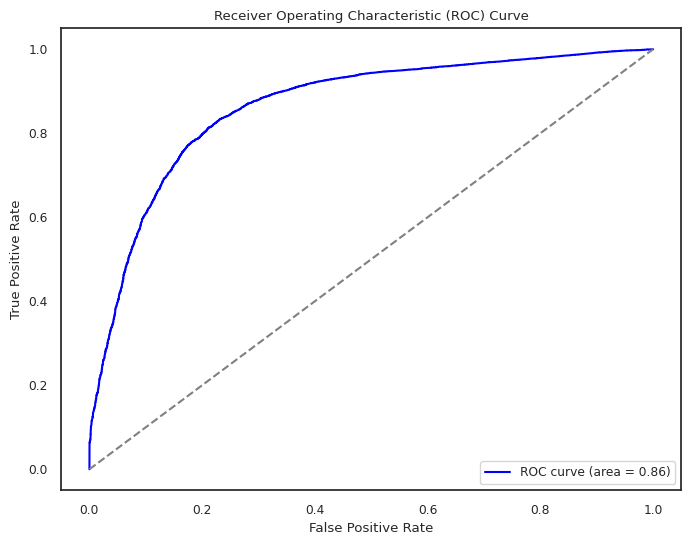

In [148]:
y_pred_prob = gbc.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<Axes: >

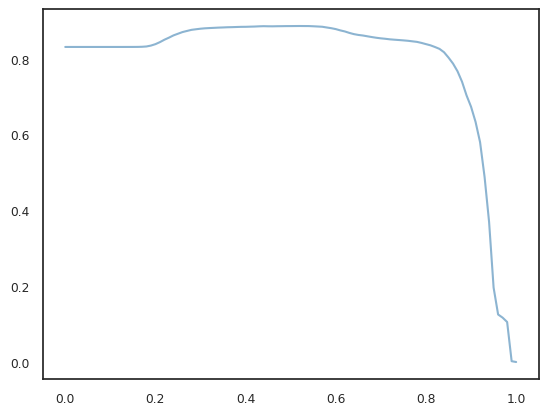

In [149]:


from sklearn.metrics import f1_score

f1 = []

thresholds = np.linspace(0, 1, 101)

for thresh in thresholds:
    y_pred =(gbc.predict_proba(X_train)[:,1]>thresh)
    f1.append(f1_score(y_train, y_pred))

sns.lineplot(x=thresholds, y=f1)

In [150]:
thresh = thresholds[f1.index(max(f1))]

thresh

np.float64(0.52)

In [151]:
preds = gbc.predict_proba(X_test)[:, 1] > thresh

print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"F1: {f1_score(y_test, preds)}")

Accuracy: 0.82865
Precision: 0.8561821692522804
Recall: 0.9103072348860257
F1: 0.8824155086635787


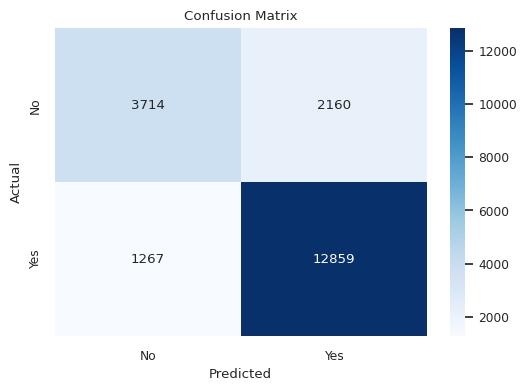

In [152]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model improvement through data balancing

In [115]:
import imblearn.over_sampling as OS
import imblearn.under_sampling as US
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original dataset size: {X_train.shape}, {y_train.shape}")

# === Original model ===
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# === Undersampling ===
RUS = US.RandomUnderSampler(sampling_strategy=1/2, random_state=42)
X_train_us, y_train_us = RUS.fit_resample(X_train, y_train)

gbc_us = GradientBoostingClassifier(n_estimators=200, random_state=42)
gbc_us.fit(X_train_us, y_train_us)

# === Oversampling ===
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
ratio = {0: n_neg * 4, 1: n_pos}  # creating 4 times more negative examples

ROS = OS.RandomOverSampler(sampling_strategy=ratio, random_state=42)
X_train_os, y_train_os = ROS.fit_resample(X_train, y_train)

gbc_os = GradientBoostingClassifier( random_state=42)
gbc_os.fit(X_train_os, y_train_os)

# === SMOTE Oversampling ===
smt = OS.SMOTE(sampling_strategy=ratio, random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

gbc_smt = GradientBoostingClassifier( random_state=42)
gbc_smt.fit(X_train_smt, y_train_smt)

# === (Accuracy) ===
print("\n=== Train Accuracy ===")
print(f"Normal Train Accuracy: {gbc.score(X_train, y_train)}")
print(f"Undersample Train Accuracy: {gbc_us.score(X_train_us, y_train_us)}")
print(f"Oversample Train Accuracy: {gbc_os.score(X_train_os, y_train_os)}")
print(f"SMOTE Train Accuracy: {gbc_smt.score(X_train_smt, y_train_smt)}")

print("\n=== Test Accuracy ===")
print(f"Normal Test Accuracy: {gbc.score(X_test, y_test)}")
print(f"Undersample Test Accuracy: {gbc_us.score(X_test, y_test)}")
print(f"Oversample Test Accuracy: {gbc_os.score(X_test, y_test)}")
print(f"SMOTE Test Accuracy: {gbc_smt.score(X_test, y_test)}")


Original dataset size: (80000, 19), (80000,)

=== Train Accuracy ===
Normal Train Accuracy: 0.8325
Undersample Train Accuracy: 0.8311134175171538
Oversample Train Accuracy: 0.8141552633693062
SMOTE Train Accuracy: 0.8417507966687197

=== Test Accuracy ===
Normal Test Accuracy: 0.8277
Undersample Test Accuracy: 0.83185
Oversample Test Accuracy: 0.778
SMOTE Test Accuracy: 0.7861


I chose Undersample because it achieved the highest test accuracy (0.83185) compared to other methods. It also provides a good balance between model performance and avoiding overfitting, which is crucial for maintaining generalization.

In [116]:
from sklearn.metrics import recall_score

# Predict test data
y_pred = gbc_us.predict(X_test)
y_pred_us = gbc_us.predict(X_test)
y_pred_os = gbc_us.predict(X_test)
y_pred_smt = gbc_us.predict(X_test)

# Presision
print(f"Normal Test Presision: {precision_score(y_test, y_pred)}")
print(f"Undersample Test Presision: {precision_score(y_test, y_pred_us)}")
print(f"Oversample Test Presision: {precision_score(y_test, y_pred_os)}")
print(f"SMOTE Test Presision: {precision_score(y_test, y_pred_smt)}")

# Recall
print(f"Normal Test Recall: {recall_score(y_test, y_pred)}")
print(f"Undersample Test Recall: {recall_score(y_test, y_pred_us)}")
print(f"Oversample Test Recall: {recall_score(y_test, y_pred_os)}")
print(f"SMOTE Test Recall: {recall_score(y_test, y_pred_smt)}")

Normal Test Presision: 0.8686211384341394
Undersample Test Presision: 0.8686211384341394
Oversample Test Presision: 0.8686211384341394
SMOTE Test Presision: 0.8686211384341394
Normal Test Recall: 0.8977063570720657
Undersample Test Recall: 0.8977063570720657
Oversample Test Recall: 0.8977063570720657
SMOTE Test Recall: 0.8977063570720657


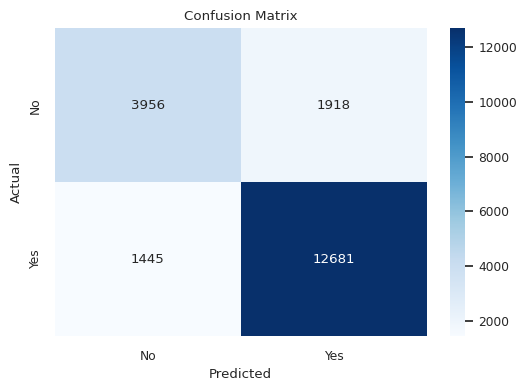

In [117]:



cm = confusion_matrix(y_test, y_pred_us)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

After applying the model balancing method, the number of predicted TN increased from 3714 to 3956.

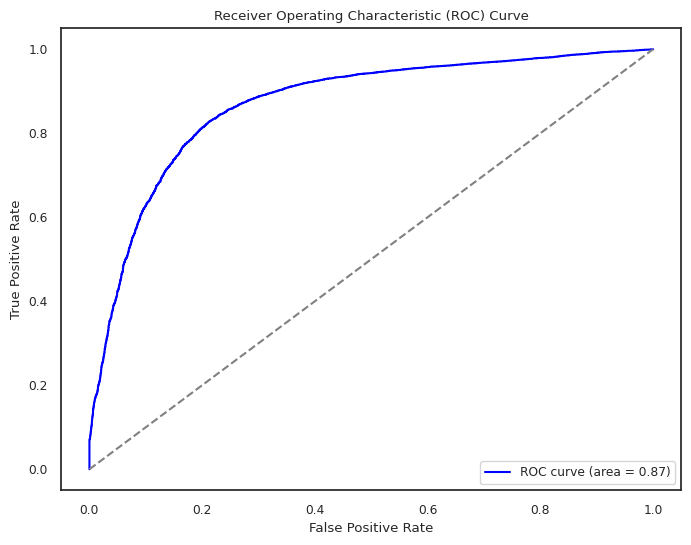

In [118]:
y_pred_prob = gbc_us.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<ipython-input-119-fc09ee3b5c1f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="feature_importance",


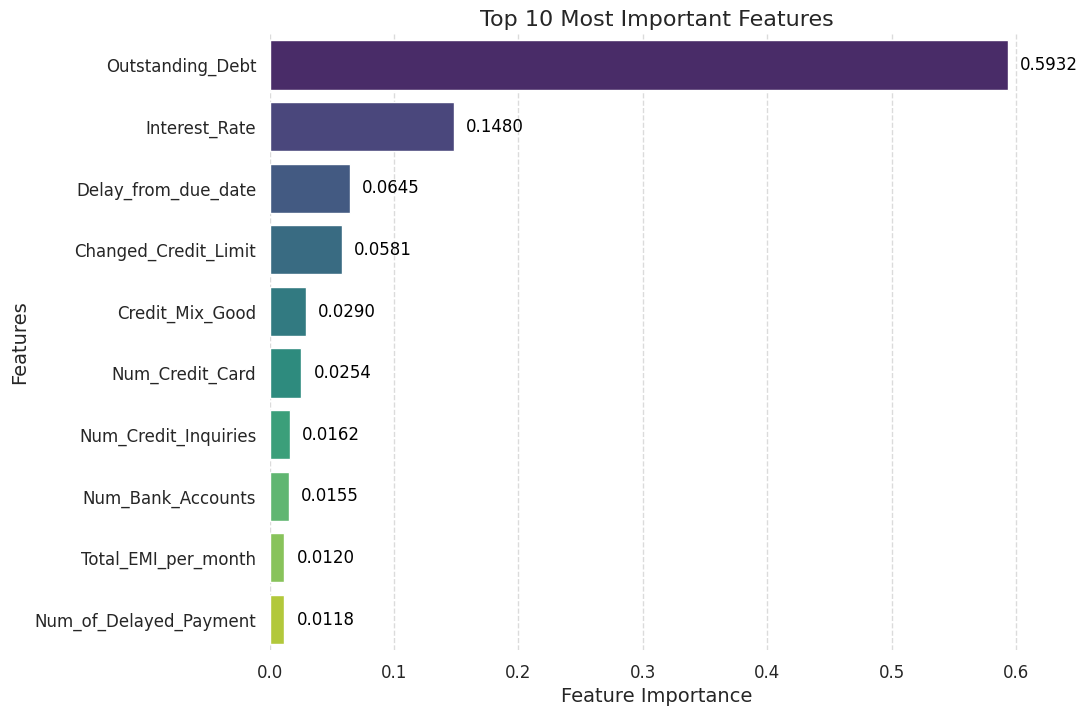

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features(columns, importances, n=10):

    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))


    plt.figure(figsize=(10, 8))
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h",
                palette="viridis")

    plt.title(f"Top {n} Most Important Features", fontsize=16)
    plt.xlabel("Feature Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)


    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    plt.grid(True, axis='x', linestyle='--', alpha=0.7)


    for i, v in enumerate(df[:n]["feature_importance"]):
        plt.text(v + 0.01, i, f"{v:.4f}", color='black', fontsize=12, va='center')


    sns.despine(left=True, bottom=True)


    plt.show()


plot_features(X_train.columns, gbc_us.feature_importances_)